In [1]:
%%capture
# Setup: Install packages we will need in this notebook
%pip install pyfmrheo
%pip install matplotlib

In [2]:
from pyfmreader import loadfile
from pyfmrheo.routines.PiezoCharacterization import doPiezoCharacterization
import matplotlib.pyplot as plt

In [3]:
# Define global parameters for plotting
plt.rcParams["figure.figsize"] = (10,5)

In [4]:
# Define path of file to process
file_path = r"../tests/testfiles/map-data-2022.10.29-11.44.12.949.jpk-force-map"

In [5]:
# Load File
file = loadfile(file_path)
filemetadata = file.filemetadata
print(filemetadata['file_type'])

jpk-force-map


In [6]:
# Get some of the file metadata
closed_loop = filemetadata['z_closed_loop']
file_deflection_sensitivity = filemetadata['defl_sens_nmbyV'] #nm/V
file_spring_constant = filemetadata['spring_const_Nbym'] #N/m
height_channel = filemetadata['height_channel_key']

deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
spring_constant = file_spring_constant

print(f"Closed loop: {closed_loop}")
print(f"Height channel: {height_channel}")
print(f"Deflection Sens.: {deflection_sensitivity} m/V")
print(f"Spring Constant: {spring_constant} N/m")

Closed loop: false
Height channel: measuredHeight
Deflection Sens.: 1.4678505383171551e-08 m/V
Spring Constant: 0.191 N/m


In [7]:
param_dict = {
    'height_channel': height_channel,   # Channel where to find the height data
    'def_sens': deflection_sensitivity, # Deflection sensitivity in m/V
    'k': spring_constant,               # Spring constant in N/m
    'max_freq': 1e3                     # Maximum frequency to process in Hz
}

In [8]:
# Select curve by index
curve_idx = 0
force_curve = file.getcurve(curve_idx)
# Preprocess curve
force_curve.preprocess_force_curve(param_dict['def_sens'], param_dict['height_channel'])
# JPK files require the height signal to be shifted
if filemetadata['file_type'] in ('jpk-force', 'jpk-force-map', 'jpk-qi-data'):
    force_curve.shift_height()

In [9]:
frequencies_results, fi_results, amp_quotient_results, gamma2_results = doPiezoCharacterization(force_curve, param_dict)

The frequency found at index 799.789529071297 does not match with the frequency applied 800.0
The frequency found at index 0.9966777408637872 does not match with the frequency applied 1.0
The frequency found at index 59.98421468034728 does not match with the frequency applied 60.0
The frequency found at index 119.96842936069456 does not match with the frequency applied 120.0
The frequency found at index 0.5980066445182725 does not match with the frequency applied 0.6
The frequency found at index 199.89479221462386 does not match with the frequency applied 200.0
The frequency found at index 9.994447529150474 does not match with the frequency applied 10.0


C:\Users\javier.lopez\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:1867: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


Text(0, 0.5, 'vDeflection [m]')

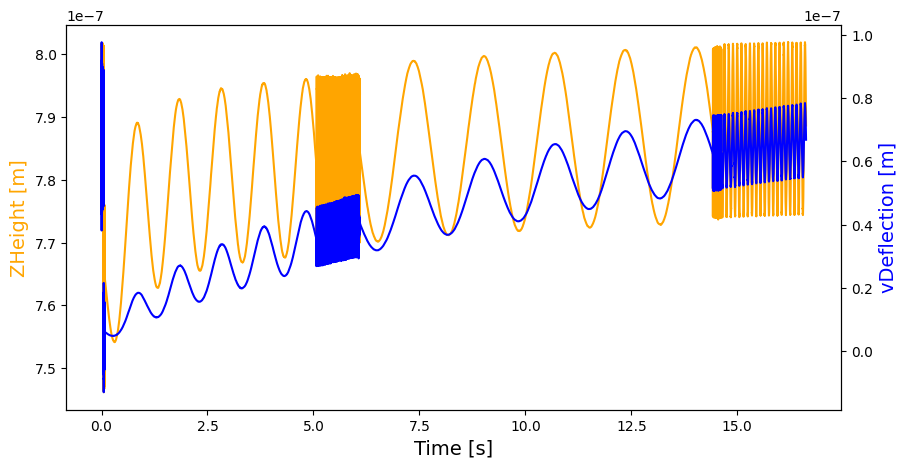

In [10]:
# Plot the force curve modulation segments
time_0 = 0
fig,ax = plt.subplots()
ax2=ax.twinx()
for _, segment in force_curve.modulation_segments:
        time = segment.time
        zheight = segment.zheight
        deflection = segment.vdeflection
        ax.plot(time + time_0, zheight, 'orange')
        ax2.plot(time + time_0, deflection, 'b')
        time_0 = time_0 + time[-1]
ax.set_xlabel("Time [s]", fontsize = 14)
ax.set_ylabel("ZHeight [m]", color="orange", fontsize=14)
ax2.set_ylabel("vDeflection [m]",color="blue",fontsize=14)

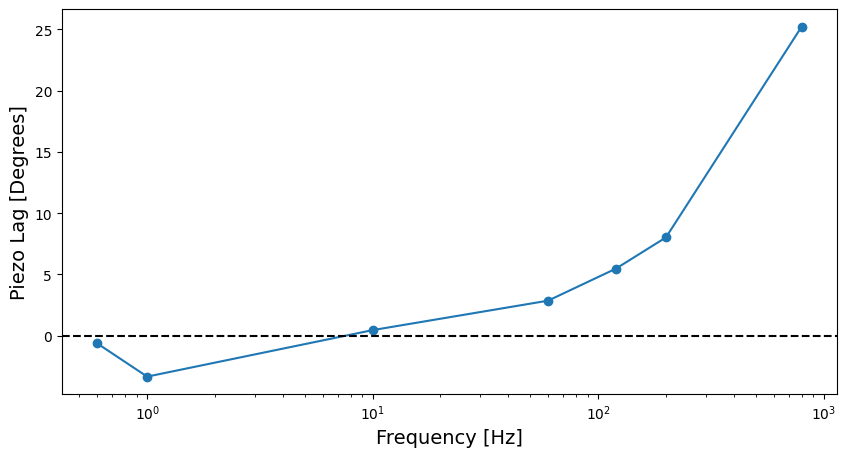

In [11]:
# Plot computed piezo lag
plt.plot(frequencies_results, fi_results, '-o')
plt.axhline(y=0, color='k', linestyle='--')
plt.xscale("log")
plt.xlabel("Frequency [Hz]", fontsize = 14)
plt.ylabel("Piezo Lag [Degrees]", fontsize = 14)
plt.show()

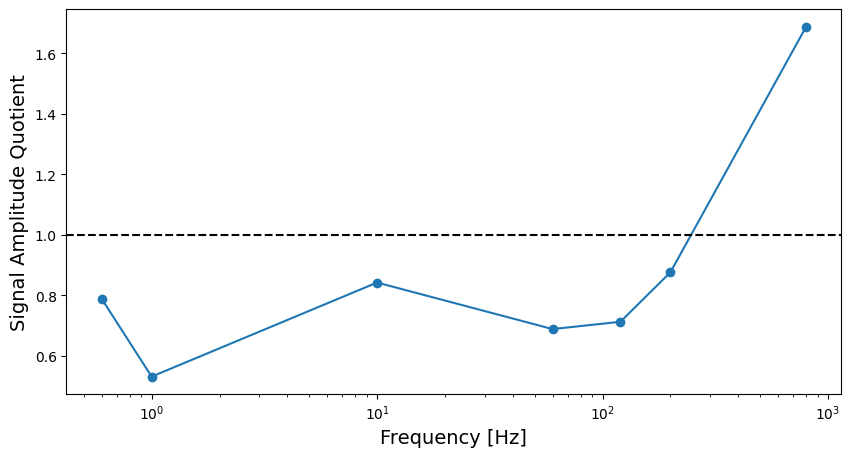

In [12]:
# Plot quotient between amplitudes
plt.plot(frequencies_results, amp_quotient_results, '-o')
plt.axhline(y=1, color='k', linestyle='--')
plt.xscale("log")
plt.xlabel("Frequency [Hz]", fontsize = 14)
plt.ylabel("Signal Amplitude Quotient", fontsize = 14)
plt.show()